# **CSC420 Assignment 2**
Muxin Tian

Task 1

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
from google.colab import drive
%matplotlib inline

In [ ]:
drive.mount('/content/drive')
SDD = ImageFolder('/content/drive/MyDrive/CSC420/Assignment 2/SDDsubset')
DBI = ImageFolder('/content/drive/MyDrive/CSC420/Assignment 2/DBIsubset')
len(DBI)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


646

In [ ]:
DBIBreeds = []

for n in DBI.classes:
    DBIBreeds.append(n)


SDDBreeds = []

for n in SDD.classes:
    SDDBreeds.append(n)

In [ ]:
random_seed = 45
torch.manual_seed(random_seed);

In [ ]:
test_pct = 0.3
test_size = int(len(DBI)*test_pct)
dataset_size = len(DBI) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size

train_size, val_size, test_size

(408, 45, 193)

In [ ]:
train_ds, val_ds, test_ds = random_split(DBI, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(408, 45, 193)

golden_retriever
<class 'PIL.Image.Image'>


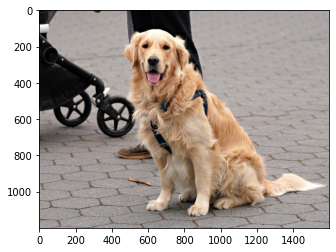

In [ ]:
# Test
img, label = train_ds[6]
print(DBI.classes[label])
plt.imshow(img)
print(type(img))

In [ ]:
class DogBreedDataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label

In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
#    transforms.Resize((224, 224)),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    
])


val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])

In [ ]:
train_dataset = DogBreedDataset(train_ds, train_transform)
val_dataset = DogBreedDataset(val_ds, val_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)
DBI = DogBreedDataset(DBI, test_transform)

SDD = DogBreedDataset(SDD, test_transform)

3


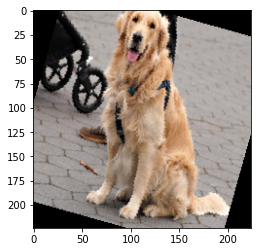

In [ ]:
img, label = train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

In [ ]:
batch_size =64

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)
SDD_dl = DataLoader(SDD, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break

In [ ]:
show_batch(SDD_dl)

KeyboardInterrupt: ignored

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.cross_entropy(out, targets)
        return loss
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.cross_entropy(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))
        

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [ ]:
class DogBreedClassificationCNN_NoDropout(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1),   # 224 * 224 * 16
            nn.ReLU(),                                   
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, stride=1, padding=1),  # 224 * 224 * 16
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # 112 * 112 * 16
            nn.Conv2d(16, 8, 3, stride=1, padding=1),   # 112 * 112 * 8
            nn.ReLU(), 
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 8, 3, stride=1, padding=1),    # 112 * 112* 8
            nn.ReLU(),
            nn.MaxPool2d(2,2),                          # 56 * 56* 8
            nn.Flatten(),
            nn.Linear(56*56*8, 32),
            nn.ReLU(),
            nn.Linear(32, 7),
            nn.LogSoftmax(dim = 1),
        )
    
    def forward(self, xb):
        return self.network(xb)

In [ ]:
class DogBreedClassificationCNN_WithDropout(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1),   # 224 * 224 * 16
            nn.ReLU(),                                   
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, stride=1, padding=1),  # 224 * 224 * 16
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # 112 * 112 * 16
            nn.Conv2d(16, 8, 3, stride=1, padding=1),   # 112 * 112 * 8
            nn.ReLU(), 
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 8, 3, stride=1, padding=1),    # 112 * 112* 8
            nn.ReLU(),
            nn.MaxPool2d(2,2),                          # 56 * 56* 8
            nn.Dropout(0.5, inplace=False),
            nn.Flatten(),
            nn.Linear(56*56*8, 32),
            nn.ReLU(),
            nn.Linear(32, 7),
            nn.Dropout(0.5, inplace=False),
            nn.LogSoftmax(dim = 1),
        )
    
    def forward(self, xb):
        return self.network(xb)

In [ ]:
class DogBreedResnet18NotTrained(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet18(pretrained=False)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
class DogBreedResnet18Trained(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet18(pretrained=True)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
class DogBreedResnet34Trained(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet34(pretrained=True)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
class DogBreedResnext32Trained(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnext50_32x4d(pretrained=True)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
# Customized model
model1 = DogBreedClassificationCNN_WithDropout()
model2 = DogBreedClassificationCNN_NoDropout()

# Resnet18 not trained
model3 = DogBreedResnet18NotTrained()

# Resnets trained 
model4 = DogBreedResnet18Trained()
model5 = DogBreedResnet34Trained()
model6 = DogBreedResnext32Trained()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

In [ ]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
SDD_dl = DeviceDataLoader(SDD_dl, device)



models = [model1, model2, model3, model4, model5, model6]

for model in models:
  # moving model to gpu
  model = to_device(model, device)

cuda


In [ ]:
from tqdm.notebook import tqdm

In [ ]:
from numpy.core.numerictypes import typecodes
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, test_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        
        # Training phase
        model.train()       
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            
            # calculates gradients
            loss.backward()
            
            # check gradient clipping 
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            # perform gradient descent and modifies the weights
            optimizer.step()
            
            # reset the gradients
            optimizer.zero_grad()
            
            # record and update lr
            lrs.append(get_lr(optimizer))
            
            # modifies the lr value
            sched.step()
            
        # Validation phase
        result = dict()
        loaders = [train_loader, test_loader]
        types = ['train_acc', 'test_acc']
        result = evaluate(model, val_loader) 
        for i in range(len(loaders)):
          loader = loaders[i]
          partial_rslt = evaluate(model, loader)
          result[types[i]] = partial_rslt['val_acc']
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history
        
    

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
# check the model 
def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = model2(imgs)                            # Change model object here
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        break
        
try_batch(train_dl)

In [ ]:
# set hyperparams
num_epochs = 10
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [ ]:
result = dict()
dls = [val_dl, train_dl, test_dl]
types = ['val_acc', 'train_acc', 'test_acc']
for i in range(len(dls)):
  loader = dls[i]
  partial_rslt = evaluate(model1, loader)
  result[types[i]] = partial_rslt['val_acc']
result

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


{'val_acc': 0.20000000298023224,
 'train_acc': 0.1599702537059784,
 'test_acc': 0.11219952255487442}

In [ ]:
history1 = fit_one_cycle(num_epochs, max_lr, model1, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)
history2 = fit_one_cycle(num_epochs, max_lr, model2, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)
history3 = fit_one_cycle(num_epochs, max_lr, model3, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_loss: 1.9511, val_loss: 1.9406, val_acc: 0.2000


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_loss: 1.9840, val_loss: 1.9440, val_acc: 0.2000


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_loss: 1.9553, val_loss: 1.9336, val_acc: 0.2000


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_loss: 1.9132, val_loss: 1.9136, val_acc: 0.2222


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_loss: 1.8619, val_loss: 1.9156, val_acc: 0.1556


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5] : train_loss: 1.8713, val_loss: 1.8445, val_acc: 0.2444


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6] : train_loss: 1.8574, val_loss: 1.8499, val_acc: 0.2000


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7] : train_loss: 1.8063, val_loss: 1.8333, val_acc: 0.1778


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8] : train_loss: 1.7900, val_loss: 1.8071, val_acc: 0.2444


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9] : train_loss: 1.7842, val_loss: 1.7947, val_acc: 0.2889


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_loss: 1.9456, val_loss: 1.9528, val_acc: 0.1111


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_loss: 1.9957, val_loss: 1.9557, val_acc: 0.1111


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_loss: 1.9409, val_loss: 1.9550, val_acc: 0.1111


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_loss: 1.9053, val_loss: 1.9415, val_acc: 0.1111


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_loss: 1.7894, val_loss: 1.9116, val_acc: 0.1333


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5] : train_loss: 1.6792, val_loss: 1.7850, val_acc: 0.2444


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6] : train_loss: 1.5812, val_loss: 1.7300, val_acc: 0.2889


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7] : train_loss: 1.4805, val_loss: 1.6572, val_acc: 0.3333


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8] : train_loss: 1.4624, val_loss: 1.6330, val_acc: 0.2667


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9] : train_loss: 1.4222, val_loss: 1.6227, val_acc: 0.3111


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_loss: 1.9779, val_loss: 1.9316, val_acc: 0.1778


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_loss: 1.9829, val_loss: 1.9465, val_acc: 0.1556


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_loss: 1.8332, val_loss: 2.2026, val_acc: 0.0889


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_loss: 1.8070, val_loss: 2.1259, val_acc: 0.1333


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_loss: 1.6936, val_loss: 2.0729, val_acc: 0.2000


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5] : train_loss: 1.6491, val_loss: 2.0368, val_acc: 0.2222


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6] : train_loss: 1.5258, val_loss: 1.8490, val_acc: 0.2000


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7] : train_loss: 1.4243, val_loss: 2.0186, val_acc: 0.2000


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8] : train_loss: 1.3852, val_loss: 1.7939, val_acc: 0.2889


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9] : train_loss: 1.3538, val_loss: 1.7692, val_acc: 0.3333


# **TASK 2 PART II and III.a**

# **Load the training history of customized model and Resnet18 for plotting and analysis.**

In [ ]:
# 1: With dropout
# 2: Without dropout
# 3: Resnet18
histories = [history1, history2, history3]
val_loss_by_model_part2 = []
train_loss_by_model_part2 = []
val_acc_by_model_part2 = []
test_acc_by_model_part2 = []
train_acc_by_model_part2 = []
time = list(range(10))
for i in range(len(histories)):
  history = histories[i]
  val_loss = []
  train_loss = []
  val_acc = []
  test_acc = []
  train_acc = []
  time = list(range(len(history)))
  for h in history:
      val_loss.append(h['val_loss'])
      train_loss.append(h['train_loss'])
      val_acc.append(h['val_acc'])
      test_acc.append(h['test_acc'])
      train_acc.append(h['train_acc'])
  val_loss_by_model_part2.append(val_loss)
  train_loss_by_model_part2.append(train_loss)
  val_acc_by_model_part2.append(val_acc)
  test_acc_by_model_part2.append(test_acc)
  train_acc_by_model_part2.append(train_acc)

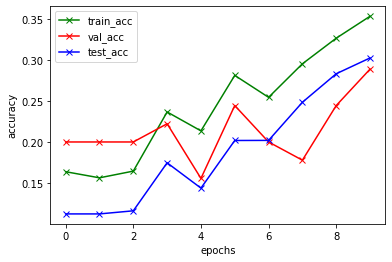

In [ ]:
show = 0
plt.plot(time, train_acc_by_model_part2[show], c='green', label='train_acc', marker='x')
plt.plot(time, val_acc_by_model_part2[show], c='red', label='val_acc', marker='x')
plt.plot(time, test_acc_by_model_part2[show], c='blue', label='test_acc', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
def predict_single(img, label, model):
    xb = img.unsqueeze(0) # adding extra dimension
    xb = to_device(xb, device)
    preds = model(xb)                   # change model object here
    predictions = preds[0]
    
    max_val, kls = torch.max(predictions, dim=0)
    # print(breeds[kls], breeds[label])
    # print(breeds)
    if DBIBreeds[label] == DBIBreeds[kls]:
      return 1
    else:
      return 0

In [ ]:
Correct = 0
for i in range(len(SDD)):
  Correct += predict_single(*SDD[i], model3)

SDDAccuracy =  float(SDD) / float(len(SDD))
SDDAccuracy

In [ ]:
history[2][9]['test_acc']

In [ ]:
history4 = fit_one_cycle(num_epochs, max_lr, model4, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)
history5 = fit_one_cycle(num_epochs, max_lr, model5, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)
history6 = fit_one_cycle(num_epochs, max_lr, model6, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)

In [ ]:
def predict_single2(img, label, m):
    xb = img.unsqueeze(0) # adding extra dimension
    xb = to_device(xb, device)
    preds = m(xb)                   # change model object here
    predictions = preds[0]
    
    max_val, kls = torch.max(predictions, dim=0)
    return SDDBreeds[label] == SDDBreeds[kls]

In [ ]:
Correct_SDD = 0
models = [model4, model5, model6]
DBI_Accuracy = []
for m in models:
  # print(type(m))
  for i in range(len(SDD)):
    if predict_single2(*SDD[i], m):
      Correct_SDD += 1
  ratio = float(SDD) / float(len(SDD))
  DBI_Accuracy.append(a)
  print('Accuracy of', type(m), ' on DBI:', ratio)

In [ ]:
# 1: Restnet18
# 2: Restnet34
# 3: Resnext32
histories2 = [history4, history5, history6]
val_loss_by_model_part3 = []
train_loss_by_model_part3 = []
val_acc_by_model_part3 = []
test_acc_by_model_part3 = []
train_acc_by_model_part3 = []
time = list(range(10))
for i in range(len(histories)):
  history = histories[i]
  val_loss = []
  train_loss = []
  val_acc = []
  test_acc = []
  train_acc = []
  time = list(range(len(history)))
  for h in history:
      val_loss.append(h['val_loss'])
      train_loss.append(h['train_loss'])
      val_acc.append(h['val_acc'])
      test_acc.append(h['test_acc'])
      train_acc.append(h['train_acc'])
  val_loss_by_model_part3.append(val_loss)
  train_loss_by_model_part3.append(train_loss)
  val_acc_by_model_part3.append(val_acc)
  test_acc_by_model_part3.append(test_acc)
  train_acc_by_model_part3.append(train_acc)

In [ ]:
time = list(range(10))
show = 0
plt.plot(time, train_loss_by_model_part3[show], c='green', label='train_acc', marker='x')
plt.plot(time, val_acc_by_model_part3[show], c='red', label='val_acc', marker='x')
plt.plot(time, test_acc_by_model_part3[show], c='blue', label='test_acc', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('Figure 4.png')
plt.show()